In [ ]:
!pip install torch
import torch
print(torch.__version__)

!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
1.12.1+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torch-geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 467 kB 14.0 MB/s 
     |████████████████████████████████| 8.9 MB 14.1 MB/s 
     |████████████████████████████████| 3.5 MB 67.8 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=7e65d66c004b92be64cf18166c7fca18d90efbcffa16b96ea029c65630b878e5
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric


In [ ]:
import os
import csv
from copy import deepcopy
import pandas as pd
import random
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np
import torch
from torch import nn
from torch_geometric import nn as gnn
from torch.nn import functional as F
from torch.utils import data
from torch import optim
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from tqdm import tqdm

In [ ]:
root_path = "drive/MyDrive/kg_Data"


def get_data(file_path, convert_to_dict = True):
  rows = []
  with open(file_path) as csvf:
    reader = csv.DictReader(csvf)
    for row in reader:
      rows.append(row)
    if convert_to_dict:
      rows = {row['name']: row for row in rows}
    return rows, reader.fieldnames


def get_relation_data(file_path, source_nodes, dest_nodes):
  rows, fieldnames = get_data(file_path, convert_to_dict=False)
  relations = [(row[fieldnames[0]], row[fieldnames[2]]) for row in rows]
  relations = [rel for rel in relations if 
               ((rel[0] in source_nodes) and (rel[1] in dest_nodes))]
  return relations

anatomy, _ = get_data(os.path.join(root_path, "anatomy.csv"))
equipment, _ = get_data(os.path.join(root_path, "equipment.csv"))
exercise, _ = get_data(os.path.join(root_path, "exercise.csv"))
muscles, _ = get_data(os.path.join(root_path, "muscles.csv"))
yoga, _ = get_data(os.path.join(root_path, "yoga.csv"))

muscle_and_anatomy = deepcopy(muscles)
muscle_and_anatomy.update(anatomy)

exercise_and_yoga = deepcopy(exercise)
exercise_and_yoga.update(yoga)

follows = get_relation_data(os.path.join(root_path, "rel_FOLLOWS_yoga.csv"), yoga, yoga)
preceds = get_relation_data(os.path.join(root_path, "rel_PRECEDS_yoga.csv"), yoga, yoga)
targets = get_relation_data(os.path.join(root_path, "rel_TARGETS.csv"), exercise, muscle_and_anatomy)
targets_yoga = get_relation_data(os.path.join(root_path, "rel_TARGETS_yoga.csv"), yoga, muscle_and_anatomy)
uses = get_relation_data(os.path.join(root_path, "rel_USES.csv"), exercise, equipment)
part_of = get_relation_data(os.path.join(root_path, "rel_PART_OF.csv"), muscle_and_anatomy, muscle_and_anatomy)

In [ ]:
len(follows), len(preceds), len(targets), len(targets_yoga), len(uses), len(part_of)

(175, 179, 3905, 478, 1424, 46)

In [ ]:
columns = {
    'anatomy': [['name']],
    'equipment': [['name']],
    'exercise': [['name'], ['difficulty', 'force_type', 'mechanics', 'type']],
    'muscles': [['name']],
    'yoga': [['name']]
}

def convert_to_list(node_maps):
  result = {}
  feature_encoders = {}
  for k, values in node_maps.items():
    curr_list = []
    for value in values.values():
      curr_value = []
      for col in columns[k][0]:
        curr_value.append(value[col])
      curr_value2 = []
      if len(columns[k]) > 1:
        for col in columns[k][1]:
          curr_value2.append(value[col])
      curr_list.append([curr_value[0], curr_value2])
    curr_list.sort(key = lambda x: x[0])
    curr_list1, curr_list2 = zip(*curr_list)
    feature_encoders[k] = [LabelEncoder()]
    result[k] = [torch.Tensor(feature_encoders[k][0].fit_transform(curr_list1)).unsqueeze(-1)]
    if len(columns[k]) > 1:
      feature_encoders[k].append(OneHotEncoder(handle_unknown='ignore'))
      result[k].append(torch.Tensor(feature_encoders[k][1].fit_transform(curr_list2).toarray()))
    result[k] = torch.cat(result[k], dim=1)
  return result, feature_encoders

In [ ]:
node_type_map = {
    'anatomy': anatomy,
    'equipment': equipment,
    'exercise': exercise,
    'muscles': muscles,
    'yoga': yoga
}

node_type_map_lookup = {}
for key, value in node_type_map.items():
  for node in value:
    node_type_map_lookup[node] = key

node_vectors, node_encoders = convert_to_list(node_type_map)

def get_index_encoder(node_map):
  nodes = [(node_type, node) for node_type, node_values in node_map.items() for node in node_values.keys()]
  nodes.sort()
  encoder = { node: index for index, (node_type, node) in enumerate(nodes)}
  return encoder, [node[1] for node in nodes]
index_encoder, index_decoder = get_index_encoder(node_type_map)

In [ ]:
class Preprocessor(nn.Module):
  def __init__(self, shapes, emb_size=256):
    super(Preprocessor, self).__init__()
    self.embedding_layers = nn.ModuleList([nn.Embedding(num_rows, (emb_size) - num_features + 1) for _, num_rows,num_features in shapes])
    self.nn_layers = nn.ModuleList([nn.Linear(emb_size, emb_size) for _ in shapes])
  
  def forward(self, nodes):
    result = []
    for i, node_vector in enumerate(nodes):
      x = self.embedding_layers[i](node_vector[:, 0].long())
      if node_vector.shape[1] > 1:
        x = torch.cat([x, node_vector[:, 1:]], dim=1)
      x = self.nn_layers[i](x)
      result.append(x)
    result = torch.cat(result, dim = 0)
    return result

In [ ]:
node_vector_shapes = [(k, value.shape[0], value.shape[1]) for k, value in node_vectors.items()]
node_vector_shapes.sort()
node_vector_list = [(k, value) for k, value in node_vectors.items()]
node_vector_list.sort(key = lambda x: x[0])
_, node_vector_list = zip(*node_vector_list)
preprocessor = Preprocessor(node_vector_shapes, emb_size=256)
for name, param in preprocessor.named_parameters():
  print(name, param.shape)
preprocessed_node_vectors = preprocessor(node_vector_list)

embedding_layers.0.weight torch.Size([24, 256])
embedding_layers.1.weight torch.Size([57, 256])
embedding_layers.2.weight torch.Size([1006, 197])
embedding_layers.3.weight torch.Size([49, 256])
embedding_layers.4.weight torch.Size([92, 256])
nn_layers.0.weight torch.Size([256, 256])
nn_layers.0.bias torch.Size([256])
nn_layers.1.weight torch.Size([256, 256])
nn_layers.1.bias torch.Size([256])
nn_layers.2.weight torch.Size([256, 256])
nn_layers.2.bias torch.Size([256])
nn_layers.3.weight torch.Size([256, 256])
nn_layers.3.bias torch.Size([256])
nn_layers.4.weight torch.Size([256, 256])
nn_layers.4.bias torch.Size([256])


In [ ]:
# verification
all_node_vectors = [x for lis in node_vector_list for x in lis]
index = random.randint(0, preprocessed_node_vectors.shape[0])
name = node_encoders[node_type_map_lookup[index_decoder[index]]][0].inverse_transform(all_node_vectors[index][0:1].long().numpy())[0]
assert(index_encoder[name] == index)
print(index)

602


In [ ]:
relations = [follows, preceds, targets, targets_yoga, uses, part_of]
edges = []
for i, relation in enumerate(relations):
  curr_edges = [[index_encoder[source], index_encoder[destination], i] for source, destination in relation]  
  curr_edges = torch.Tensor(np.array(curr_edges))
  edges.append(curr_edges)
edges = torch.cat(edges, dim = 0)
print(edges.shape)

torch.Size([6207, 3])


In [ ]:
NUM_RELATION_TYPES = len(np.unique(edges[:, 2]))
NUM_RELATIONS = edges.shape[0]
NUM_NODES = preprocessed_node_vectors.shape[0]
NODE_VECTOR_LENGTH = preprocessed_node_vectors.shape[1]

In [ ]:
class GCNEncoder(nn.Module):
  def __init__(self, layers):
    super(GCNEncoder, self).__init__()
    self.gcns = nn.ModuleList([gnn.RGCNConv(layers[i], layers[i+1], num_relations=NUM_RELATION_TYPES) for i in range(len(layers) - 1)])
  
  def forward(self, x, edges):
    edge_indices = edges[:, :2].reshape((2, NUM_RELATIONS)).long()
    edge_types = edges[:, 2].long()
    num_gcns = len(self.gcns)
    for i, gcn in enumerate(self.gcns):
      x = gcn(x, edge_indices, edge_types)
      if i < (num_gcns - 1):
        x = F.relu(x)
    return x

In [ ]:
layers = [NODE_VECTOR_LENGTH, 512, 256, 128]
gcn_encoder = GCNEncoder(layers)
node_embeddings = gcn_encoder(preprocessed_node_vectors, edges)

In [ ]:
positive_targets = targets + targets_yoga
positive_uses = uses

In [ ]:
targets_df = pd.DataFrame(positive_targets, columns=["exercise", "anatomy"])
targets_df.groupby("exercise").agg({ "anatomy": "count"}).reset_index()["anatomy"].mean()

4.013736263736264

In [ ]:
uses_df = pd.DataFrame(positive_uses, columns=["exercise", "equipment"])
uses_df.groupby("exercise").agg({ "equipment": "count"}).reset_index()["equipment"].mean()

1.415506958250497

In [ ]:
negative_targets = []
negative_uses = []
for exercise in tqdm(exercise_and_yoga.keys()):
  valid_muscles = [m for m in muscle_and_anatomy.keys() if (exercise, m) not in positive_targets]
  for m in random.sample(valid_muscles, 5):
    negative_targets.append((exercise, m))
  valid_equipments = [m for m in equipment.keys() if (exercise, m) not in positive_uses]
  for m in random.sample(valid_equipments, 2):
    negative_uses.append((exercise, m))
  

100%|██████████| 1098/1098 [00:22<00:00, 47.89it/s]


In [ ]:
target_pairs = [(index_encoder[t[0]], index_encoder[t[1]], 1) for t in positive_targets] + [(index_encoder[t[0]], index_encoder[t[1]], 0) for t in negative_targets]
uses_pairs = [(index_encoder[t[0]], index_encoder[t[1]], 1) for t in positive_uses] + [(index_encoder[t[0]], index_encoder[t[1]], 0) for t in negative_uses]
target_pairs = target_pairs + uses_pairs

target_pairs = np.array(target_pairs)
train_target_pair_x, test_target_pair_x, train_target_pair_y, test_target_pair_y = train_test_split(target_pairs[:,:2], target_pairs[:, 2], stratify=target_pairs[:, 2], test_size=0.2)

In [ ]:
train_target_pair_x.shape, train_target_pair_y.shape, test_target_pair_x.shape, test_target_pair_y.shape

((10794, 2), (10794,), (2699, 2), (2699,))

In [ ]:
# defining dataset class for dataloader
class PairDataset(data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        assert(len(self.x) == len(self.y))

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


dummy_dataset = PairDataset(train_target_pair_x,train_target_pair_y)
dummy_dataloader = data.DataLoader(dummy_dataset, batch_size=32, shuffle=True)
output , labels = next(iter(dummy_dataloader))
print(output.shape)
print(labels)

torch.Size([32, 2])
tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 0])


In [ ]:
train_target_dataset = PairDataset(train_target_pair_x,train_target_pair_y)
train_target_dataloader = data.DataLoader(train_target_dataset, batch_size=32, shuffle=True)

test_target_dataset = PairDataset(test_target_pair_x,test_target_pair_y)
test_target_dataloader = data.DataLoader(test_target_dataset, batch_size=32, shuffle=True)

In [ ]:
# training and evaluation functions
def send_to_device(tensor):
    if (type(tensor) == list) or (type(tensor) == tuple):
        return [send_to_device(tenr) for tenr in tensor]
    if (type(tensor) == dict):
        return {k: send_to_device(v) for k, v in tensor.items()}
    elif torch.is_tensor(tensor):
        return tensor.to("cuda")
    else:
        return tensor


def train_one_epoch(model, nodes, edges, train_data_loader, optimizer, loss_fn, scheduler):
    running_loss = 0.
    last_loss = 0.
    pb = tqdm(enumerate(train_data_loader))
    for i, data in pb:
        inp, labels = data
        labels = labels
        if torch.cuda.is_available():
            inp = send_to_device(inp)
            labels = send_to_device(labels)
            edges = send_to_device(edges)
            nodes = send_to_device(nodes)
        optimizer.zero_grad()
        outputs = model(nodes, edges, inp)
        loss = loss_fn(outputs, labels.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        running_loss += loss.item()
        pb.set_description('batch {} loss: {}'.format(i + 1, loss.item()))
        if i % 10 == 9:
            scheduler.step()
        del inp, labels
        model.zero_grad()
    return running_loss / len(train_data_loader.dataset)


def save_model(model, save_dir="."):
    model_path = os.path.join(save_dir, model.name)
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    model_path = os.path.join(model_path, "weights")
    torch.save(model.state_dict(), model_path)

# model training
def train_model(model, nodes, edges, train_data_loader, val_data_loader=None, epochs=30, lr=1e-5, batch_size=16, scheduler_params = None):
    print("========================================================")
    print(f"TRAINING {model.name}")
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, eps=1e-8)
    decayRate = 0.90
    if scheduler_params == None:
        scheduler_params = {
            "name": optim.lr_scheduler.ExponentialLR,
            "params": {
                "verbose": True,
                "gamma": 0.99
            }
        }
    scheduler = scheduler_params["name"](
        optimizer=optimizer,**scheduler_params["params"])

    best_vloss = 1000000.
    best_model_state_dict = None
    train_losses = []
    val_losses = []
    if torch.cuda.is_available():
        model = model.to("cuda")
    model.zero_grad()
    for epoch in range(epochs):
        print('EPOCH {}:'.format(epoch + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(
            model, nodes, edges, train_data_loader, optimizer, loss_fn, scheduler)
        train_losses.append(avg_loss)
        if val_data_loader is not None:
            # We don't need gradients on to do reporting
            model.train(False) 
            running_vloss = 0.0
            for i, vdata in enumerate(val_data_loader):
                vinp, vlabels = vdata
                if torch.cuda.is_available():
                    vinp = send_to_device(vinp)
                    nodes = send_to_device(nodes)
                    edges = send_to_device(edges)
                    vlabels = send_to_device(vlabels)
                with torch.no_grad():
                    voutputs = model(nodes, edges, vinp)
                    vloss = loss_fn(voutputs, vlabels.float())
                    running_vloss += vloss
            avg_vloss = running_vloss / (i + 1)
            del vinp, vlabels
            val_losses.append(avg_vloss.cpu())
        else:
            print("validation data loader not provided. Hence, validation error will be same as training error")
            avg_vloss = avg_loss

        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            del best_model_state_dict
            best_model_state_dict = deepcopy(model.state_dict())
            save_model(model)
    print(f"the best loss is {best_vloss}")
    model.state_dict(best_model_state_dict)
    return train_losses, val_losses


def evaluate(model, nodes, edges, dataloader, labels, working_dir="."):
    print("========================================================")
    print(f"EVALUATING {model.name}")
    outputs = []
    true_classes = []
    sigmoid = nn.Sigmoid()
    if torch.cuda.is_available():
        sigmoid = sigmoid.to("cuda")
    num_labels = list(range(len(labels)))
    for i, data in enumerate(dataloader):
        inp, true_class = data
        if torch.cuda.is_available():
            inp = send_to_device(inp)
            model = model.to("cuda")
            nodes = send_to_device(nodes)
            edges = send_to_device(edges)
        with torch.no_grad():
            output = model(nodes, edges, inp)
            output = sigmoid(output)
        output = torch.where(output >= 0.5, 1, 0)
        output = output.cpu().numpy()
        outputs.extend(output.tolist())
        true_classes.extend(true_class.tolist())
    precision = precision_score(
        true_classes, outputs, labels=num_labels, average="binary")
    recall = recall_score(true_classes, outputs,
                          labels=num_labels, average="binary")
    f1 = f1_score(true_classes, outputs, labels=num_labels, average="binary")
    accuracy = accuracy_score(true_classes, outputs)
    print(f"precision: {precision}")
    print(f"recall: {recall}")
    print(f"f1 score: {f1}")
    print(f"accuracy: {accuracy}")
    cf = confusion_matrix(true_classes, outputs, labels=num_labels)
    plt.figure(figsize=(10, 10))
    cf_dataframe = pd.DataFrame(cf, columns=labels, index=labels)
    sns.heatmap(cf_dataframe, annot=True, linewidths=.5, cmap="YlGnBu")
    plt.show()
    return (precision, recall, f1)

In [ ]:
class PairDecoder(nn.Module):
  def __init__(self):
    super(PairDecoder, self).__init__()
  
  def forward(self, node_embeddings, inp):
    src_embeddings = node_embeddings[inp[:, 0].long()]
    dest_embeddings = node_embeddings[inp[:, 1].long()]
    return torch.sum(src_embeddings * dest_embeddings, axis=1)

pair_decoder = PairDecoder()
output = pair_decoder(node_embeddings, torch.Tensor(train_target_pair_x))
print(output)

tensor([ 88.2966,  30.8720,  80.0594,  ...,  51.3117, 129.1353,  56.7068],
       grad_fn=<SumBackward1>)


In [ ]:
class GCNModel(nn.Module):
  def __init__(self, node_vector_shapes, layers, emb_size=256, name = 'gcn_model'):
    super(GCNModel, self).__init__()
    self.name = name
    self.preprocessor = Preprocessor(node_vector_shapes, emb_size=emb_size)
    layers = [emb_size] + layers
    self.gcn_encoder = GCNEncoder(layers)
    self.pair_decoder = PairDecoder()
  
  def forward(self, nodes, edges, inp):
    preprocessed_nodes = self.preprocessor(nodes)
    node_embeddings = self.gcn_encoder(preprocessed_nodes, edges)
    return self.pair_decoder(node_embeddings, inp)

gcn_model = GCNModel(node_vector_shapes, layers=[512, 256, 128], emb_size=256)
gcn_model(node_vector_list, edges, torch.Tensor(train_target_pair_x))

tensor([ 50.9296,  35.5994,  53.6756,  ...,  52.5949, 114.8929,  73.8575],
       grad_fn=<SumBackward1>)

In [ ]:
gcn_model = GCNModel(node_vector_shapes, layers=[512, 256, 128], emb_size=256)
train_target_dataset = PairDataset(train_target_pair_x,train_target_pair_y)
train_target_dataloader = data.DataLoader(train_target_dataset, batch_size=64, shuffle=True)

test_target_dataset = PairDataset(test_target_pair_x,test_target_pair_y)
test_target_dataloader = data.DataLoader(test_target_dataset, batch_size=64, shuffle=True)

scheduler_params = {
            "name": optim.lr_scheduler.ExponentialLR,
            "params": {
                "verbose": False,
                "gamma": 0.99
            }
        }


train_losses, val_losses = train_model(gcn_model, node_vector_list, edges, train_target_dataloader, test_target_dataloader,
                                       epochs=50, scheduler_params = scheduler_params, batch_size = 64)

TRAINING gcn_model
EPOCH 1:


batch 169 loss: 1.2077088356018066: : 169it [00:12, 13.23it/s]


LOSS train 0.06345278734804768 valid 1.4898864030838013
EPOCH 2:


batch 169 loss: 0.7294897437095642: : 169it [00:04, 39.94it/s]


LOSS train 0.016260392415826136 valid 0.9668117761611938
EPOCH 3:


batch 169 loss: 0.5427905321121216: : 169it [00:04, 40.86it/s]


LOSS train 0.011375310756397266 valid 0.8124424815177917
EPOCH 4:


batch 169 loss: 0.8553263545036316: : 169it [00:04, 40.19it/s]


LOSS train 0.009447785473673878 valid 0.7418997287750244
EPOCH 5:


batch 169 loss: 0.40909668803215027: : 169it [00:04, 40.05it/s]


LOSS train 0.008335137656602194 valid 0.7011764645576477
EPOCH 6:


batch 169 loss: 0.527130663394928: : 169it [00:06, 24.24it/s]


LOSS train 0.007644248169970906 valid 0.6908693313598633
EPOCH 7:


batch 169 loss: 0.4360870122909546: : 169it [00:05, 29.81it/s]


LOSS train 0.00714140031013927 valid 0.6606795787811279
EPOCH 8:


batch 169 loss: 0.48658108711242676: : 169it [00:05, 29.14it/s]


LOSS train 0.0067849064317261135 valid 0.646618127822876
EPOCH 9:


batch 169 loss: 0.6404510736465454: : 169it [00:06, 27.00it/s]


LOSS train 0.006507926988274781 valid 0.6465071439743042
EPOCH 10:


batch 169 loss: 0.4358961582183838: : 169it [00:05, 33.50it/s]


LOSS train 0.006286114836669044 valid 0.6639609336853027
EPOCH 11:


batch 169 loss: 0.2013590782880783: : 169it [00:04, 40.67it/s]


LOSS train 0.006103771549751521 valid 0.626664400100708
EPOCH 12:


batch 169 loss: 0.3565713167190552: : 169it [00:04, 39.63it/s]


LOSS train 0.0059638572237282654 valid 0.627898633480072
EPOCH 13:


batch 169 loss: 0.3444306552410126: : 169it [00:04, 40.54it/s]


LOSS train 0.005849817783960219 valid 0.637347400188446
EPOCH 14:


batch 169 loss: 0.40323376655578613: : 169it [00:06, 27.91it/s]


LOSS train 0.0057575329337514105 valid 0.6130871176719666
EPOCH 15:


batch 169 loss: 0.30877622961997986: : 169it [00:06, 26.51it/s]


LOSS train 0.0056736191207664155 valid 0.6093601584434509
EPOCH 16:


batch 169 loss: 0.296509325504303: : 169it [00:06, 25.30it/s]


LOSS train 0.005607361873697744 valid 0.6196402311325073
EPOCH 17:


batch 169 loss: 0.3838789463043213: : 169it [00:04, 36.03it/s]


LOSS train 0.005553610448939327 valid 0.6153740286827087
EPOCH 18:


batch 169 loss: 0.32788145542144775: : 169it [00:05, 31.10it/s]


LOSS train 0.005506641275135703 valid 0.6079737544059753
EPOCH 19:


batch 169 loss: 0.34322044253349304: : 169it [00:06, 27.31it/s]


LOSS train 0.0054696377464106775 valid 0.6086909174919128
EPOCH 20:


batch 169 loss: 0.453158974647522: : 169it [00:04, 40.05it/s]


LOSS train 0.005439860315892307 valid 0.6042482852935791
EPOCH 21:


batch 169 loss: 0.24244904518127441: : 169it [00:04, 40.30it/s]


LOSS train 0.005405052111715172 valid 0.6032735109329224
EPOCH 22:


batch 169 loss: 0.36283519864082336: : 169it [00:06, 26.27it/s]


LOSS train 0.005386103080592156 valid 0.6094936728477478
EPOCH 23:


batch 169 loss: 0.4056451916694641: : 169it [00:04, 40.63it/s]


LOSS train 0.005367420539218496 valid 0.6123618483543396
EPOCH 24:


batch 169 loss: 0.36405542492866516: : 169it [00:04, 41.17it/s]


LOSS train 0.005349964037336021 valid 0.6107862591743469
EPOCH 25:


batch 169 loss: 0.3012268841266632: : 169it [00:05, 33.68it/s]


LOSS train 0.005333220419484817 valid 0.6055868864059448
EPOCH 26:


batch 169 loss: 0.23340731859207153: : 169it [00:04, 38.65it/s]


LOSS train 0.00531899249700566 valid 0.6062564849853516
EPOCH 27:


batch 169 loss: 0.30335795879364014: : 169it [00:05, 30.48it/s]


LOSS train 0.005310700971295663 valid 0.6032342910766602
EPOCH 28:


batch 169 loss: 0.2155042439699173: : 169it [00:05, 30.27it/s]


LOSS train 0.0052998197344866025 valid 0.6099045872688293
EPOCH 29:


batch 169 loss: 0.3089357912540436: : 169it [00:04, 35.42it/s]


LOSS train 0.005295424395818412 valid 0.5990433096885681
EPOCH 30:


batch 169 loss: 0.4625052511692047: : 169it [00:04, 37.99it/s]


LOSS train 0.005293790168876623 valid 0.6169752478599548
EPOCH 31:


batch 169 loss: 0.3948391079902649: : 169it [00:05, 31.51it/s]


LOSS train 0.005286431877739411 valid 0.6002269387245178
EPOCH 32:


batch 169 loss: 0.36842405796051025: : 169it [00:05, 31.40it/s]


LOSS train 0.005281038172315265 valid 0.6107208132743835
EPOCH 33:


batch 169 loss: 0.4301013648509979: : 169it [00:06, 28.09it/s]


LOSS train 0.005279245785160906 valid 0.6049257516860962
EPOCH 34:


batch 169 loss: 0.2951202392578125: : 169it [00:05, 30.87it/s]


LOSS train 0.005271681751976505 valid 0.6033490896224976
EPOCH 35:


batch 169 loss: 0.36172565817832947: : 169it [00:05, 28.62it/s]


LOSS train 0.005271023868608855 valid 0.6117686033248901
EPOCH 36:


batch 169 loss: 0.32450026273727417: : 169it [00:05, 30.93it/s]


LOSS train 0.005267478734094698 valid 0.6093476414680481
EPOCH 37:


batch 169 loss: 0.3843969702720642: : 169it [00:05, 32.17it/s]


LOSS train 0.005267426250090042 valid 0.604564368724823
EPOCH 38:


batch 169 loss: 0.3626234531402588: : 169it [00:04, 35.94it/s]


LOSS train 0.005265068996553402 valid 0.6318264603614807
EPOCH 39:


batch 169 loss: 0.41163209080696106: : 169it [00:04, 40.84it/s]


LOSS train 0.0052651187499209605 valid 0.6107187271118164
EPOCH 40:


batch 169 loss: 0.36833009123802185: : 169it [00:04, 37.56it/s]


LOSS train 0.005262476841962092 valid 0.6074361801147461
EPOCH 41:


batch 169 loss: 0.4320187568664551: : 169it [00:04, 41.05it/s]


LOSS train 0.005263445462996327 valid 0.6002524495124817
EPOCH 42:


batch 169 loss: 0.2787582278251648: : 169it [00:06, 27.17it/s]


LOSS train 0.005257669152242951 valid 0.6014639139175415
EPOCH 43:


batch 169 loss: 0.2726059556007385: : 169it [00:06, 27.89it/s]


LOSS train 0.0052567244594861826 valid 0.6072916388511658
EPOCH 44:


batch 169 loss: 0.25323083996772766: : 169it [00:04, 40.22it/s]


LOSS train 0.005255476914502215 valid 0.6120681762695312
EPOCH 45:


batch 169 loss: 0.5208153128623962: : 169it [00:04, 40.27it/s]


LOSS train 0.005263469667374613 valid 0.6143167614936829
EPOCH 46:


batch 169 loss: 0.2818273603916168: : 169it [00:04, 35.31it/s]


LOSS train 0.005255439240545482 valid 0.6010787487030029
EPOCH 47:


batch 169 loss: 0.2783249616622925: : 169it [00:04, 40.03it/s]


LOSS train 0.005255024111920294 valid 0.6050530076026917
EPOCH 48:


batch 169 loss: 0.4120039641857147: : 169it [00:04, 41.13it/s]


LOSS train 0.00525899585671219 valid 0.6140750050544739
EPOCH 49:


batch 169 loss: 0.303337961435318: : 169it [00:04, 40.14it/s]


LOSS train 0.005255350523830366 valid 0.6096916198730469
EPOCH 50:


batch 169 loss: 0.2767138183116913: : 169it [00:04, 40.81it/s]


LOSS train 0.0052543592307773895 valid 0.6048410534858704
the best loss is 0.5990433096885681


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1366: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  "Positional args are being deprecated, use kwargs instead. Refer to "


EVALUATING gcn_model
precision: 0.7000753579502638
recall: 0.7994836488812392
f1 score: 0.7464845319405384
accuracy: 0.7662097072989996


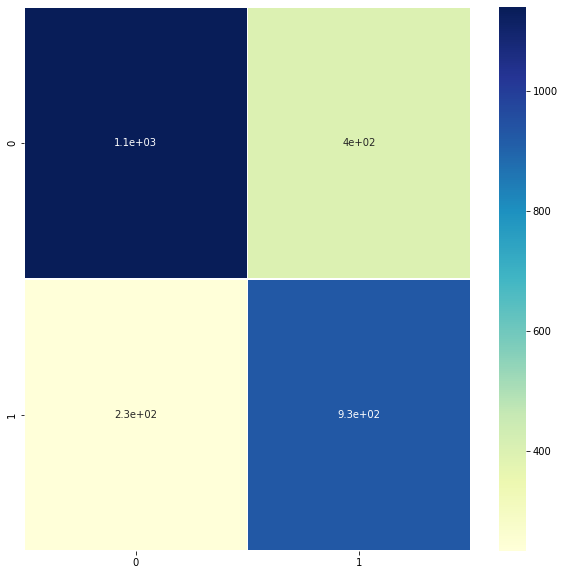

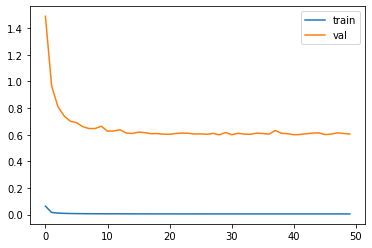

In [ ]:
evaluate(gcn_model, node_vector_list, edges, test_target_dataloader, [0, 1])
plt.figure()
plt.plot(train_losses)
plt.plot([l.cpu() for l in val_losses])
plt.legend(["train","val"])
plt.show()

In [ ]:
preprocessed_node_vectors = gcn_model.preprocessor(send_to_device(node_vector_list))
node_embeddings = gcn_model.gcn_encoder(preprocessed_node_vectors, send_to_device(edges))
print(node_embeddings)

tensor([[-0.3440, -0.0099, -0.9674,  ..., -0.9776, -0.0922, -0.8979],
        [ 0.7179,  0.1215, -0.4239,  ..., -0.2927,  0.1936,  0.0482],
        [ 0.6437, -0.1012,  0.5518,  ...,  0.1124, -0.7340, -0.1344],
        ...,
        [ 0.1441,  0.5823,  0.1317,  ...,  0.4407,  0.5274, -0.0348],
        [ 0.0606,  0.6932, -0.3479,  ..., -0.3015,  0.3388, -0.1991],
        [ 0.1153,  0.0676,  0.3040,  ...,  0.2021, -0.1536,  0.0445]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
from sklearn.cluster import AgglomerativeClustering
agglomerative_algo = AgglomerativeClustering(n_clusters=None, affinity= 'cosine', linkage='average', distance_threshold = 0.9)
clusters = agglomerative_algo.fit_predict(node_embeddings.cpu().detach())

In [ ]:
np.unique(clusters)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [ ]:
result_df = pd.DataFrame(list(zip(index_decoder, clusters)), columns = ['name', 'cluster'])
result_df.to_csv("cluster_unsupervised.csv")

In [ ]:
NUM_RELATIONS

6207

In [ ]:
includes, fieldnames = get_data(os.path.join(root_path, "rel_INCLUDES_exercise.csv"), convert_to_dict=False)
workout_sessions = [row['workout_name'] for row in includes]
